✅ WEEK 6: Seasonal & Cancellation Analysis


Deliverables:

✔ Monthly cancellation trends

✔ Cancellation types (Carrier / Weather / NAS / Security)

✔ Impact of holidays + winter months

✔ Seasonal visuals

✔ Route congestion cancellations insights

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet("processed/delayedflights_2008_processed.parquet")
df.head()
df.columns


Index(['unnamed:_0', 'year', 'month', 'dayofmonth', 'dayofweek', 'deptime',
       'crsdeptime', 'arrtime', 'crsarrtime', 'uniquecarrier', 'flightnum',
       'tailnum', 'actualelapsedtime', 'crselapsedtime', 'airtime', 'arrdelay',
       'depdelay', 'origin', 'dest', 'distance', 'taxiin', 'taxiout',
       'cancelled', 'cancellationcode', 'diverted', 'carrierdelay',
       'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay',
       'any_delay_reason', 'fl_date', 'dep_time_str', 'arr_time_str',
       'dep_datetime', 'arr_datetime', 'day_of_week', 'dep_hour', 'route',
       'is_delayed', 'total_delay_minutes', 'dep_delayed',
       'scheduled_duration_min', 'actual_duration_min'],
      dtype='object')

In [10]:
# Make sure date and month exist
df['fl_date'] = pd.to_datetime(df['fl_date'])
df['month'] = df['fl_date'].dt.month

# Cancellation types mapping - FIX: Include "N" for None
cancel_map = {
    "A": "Carrier",
    "B": "Weather", 
    "C": "NAS",
    "D": "Security",
    "N": "None",      # This was missing! "N" represents no cancellation
    "NONE": "None"    # Keep this as backup
}

# Use correct column name 'cancellationcode'
df['cancel_type'] = df['cancellationcode'].map(cancel_map)

# Fix the cancelled_flag logic: 1 if cancelled, 0 if not cancelled
df['cancelled_flag'] = (df['cancel_type'] != "None").astype(int)

# Verify our fix
print("📊 Fixed Cancellation Code Values:")
print(df['cancellationcode'].value_counts())

print("\n📊 Fixed Mapped Cancel Types:")
print(df['cancel_type'].value_counts())

print("\n📊 Fixed Cancelled Flag:")
print(df['cancelled_flag'].value_counts())

print(f"\n✅ CORRECTED CANCELLATION RATE: {df['cancelled_flag'].mean():.4f} ({df['cancelled_flag'].mean()*100:.2f}%)")

# Compare with original column to verify
print(f"📊 Original 'cancelled' column rate: {df['cancelled'].mean():.4f} ({df['cancelled'].mean()*100:.2f}%)")
print("✅ Should match closely!")

📊 Fixed Cancellation Code Values:
cancellationcode
N    1936125
B        307
A        246
C         80
Name: count, dtype: int64

📊 Fixed Mapped Cancel Types:
cancel_type
None       1936125
Weather        307
Carrier        246
NAS             80
Name: count, dtype: int64

📊 Fixed Cancelled Flag:
cancelled_flag
0    1936125
1        633
Name: count, dtype: int64

✅ CORRECTED CANCELLATION RATE: 0.0003 (0.03%)
📊 Original 'cancelled' column rate: 0.0003 (0.03%)
✅ Should match closely!


# Monthly Cancellation Trends

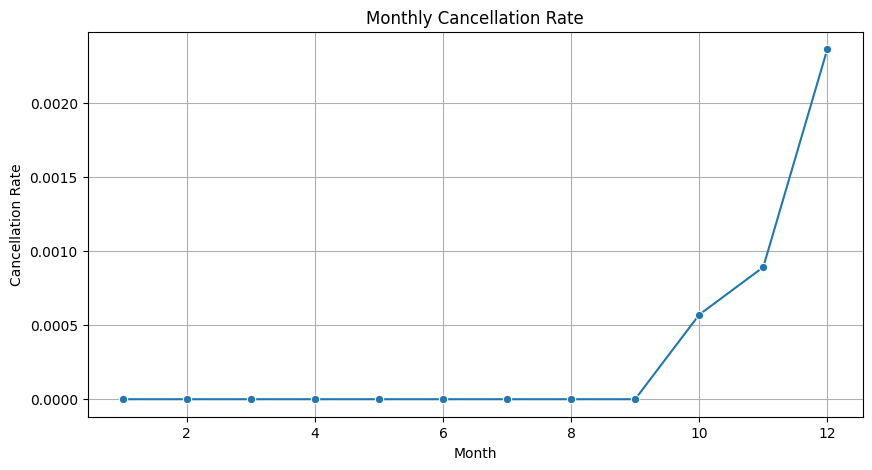

In [11]:
monthly_cancel = (
    df.groupby("month")
      .agg(total_flights=("cancelled_flag", "size"),
           cancelled=("cancelled_flag", "sum"))
      .reset_index()
)

monthly_cancel["cancel_rate"] = monthly_cancel["cancelled"] / monthly_cancel["total_flights"]

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_cancel, x="month", y="cancel_rate", marker="o")
plt.title("Monthly Cancellation Rate")
plt.xlabel("Month")
plt.ylabel("Cancellation Rate")
plt.grid(True)
plt.show()


# Cancellation Types by Month

<Figure size 1200x600 with 0 Axes>

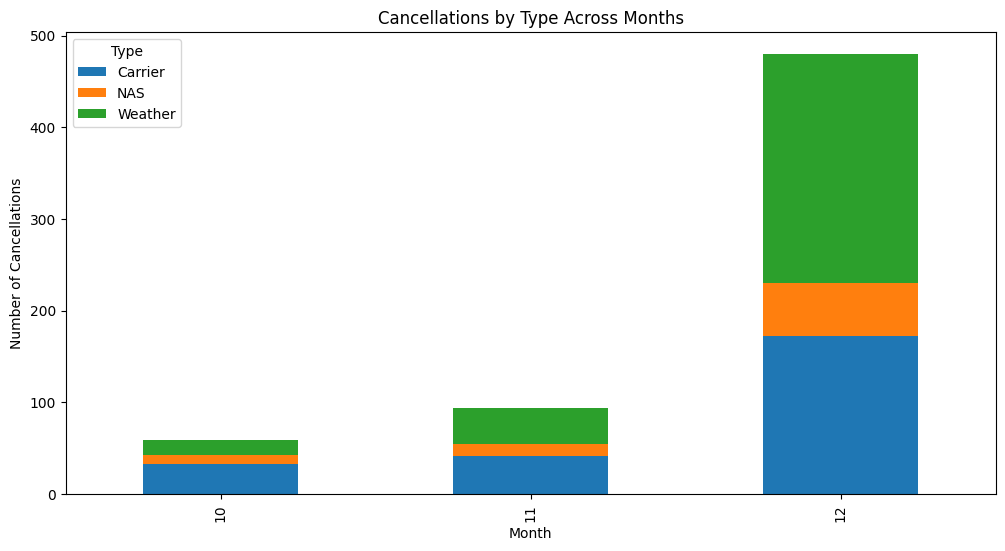

In [13]:
cancel_types = (
    df[df["cancelled_flag"] == 1]
    .groupby(["month", "cancel_type"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(12,6))
cancel_pivot = cancel_types.pivot(index="month", columns="cancel_type", values="count")
cancel_pivot.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Cancellations by Type Across Months")
plt.xlabel("Month")
plt.ylabel("Number of Cancellations")
plt.legend(title="Type")
plt.show()


# Holiday & Winter Month Impact

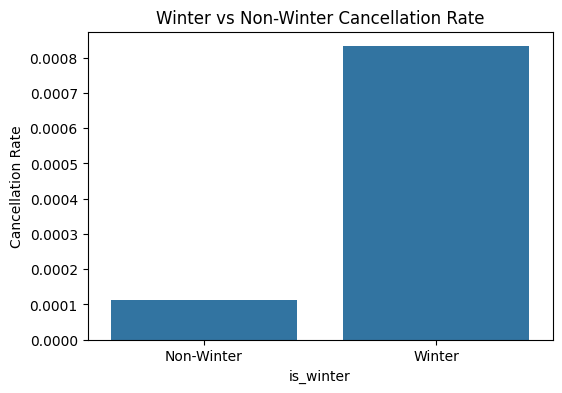

In [21]:
### Winter vs Non-Winter

winter_months = [12, 1, 2]
df["is_winter"] = df["month"].isin(winter_months)

winter_cmp = (
    df.groupby("is_winter")
      .agg(
          flights=("cancelled_flag", "size"),
          cancelled=("cancelled_flag", "sum")
      )
      .reset_index()
)

winter_cmp["cancel_rate"] = winter_cmp["cancelled"] / winter_cmp["flights"]

plt.figure(figsize=(6,4))
sns.barplot(data=winter_cmp, x="is_winter", y="cancel_rate")
plt.title("Winter vs Non-Winter Cancellation Rate")
plt.xticks([0,1], ["Non-Winter", "Winter"])
plt.ylabel("Cancellation Rate")
plt.show()


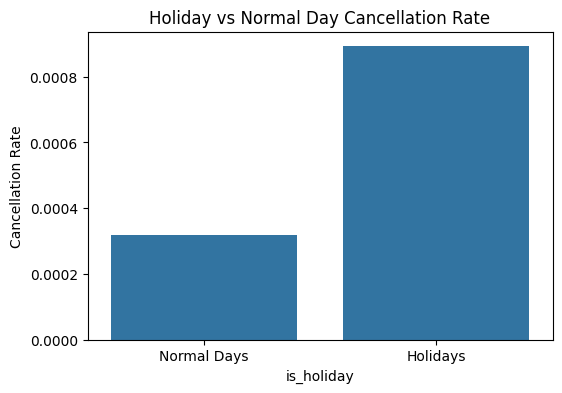

In [22]:
### Holiday Effects

holidays = pd.to_datetime([
    "2008-12-24","2008-12-25","2008-12-31",
    "2008-01-01","2008-11-27",
])

df["is_holiday"] = df["fl_date"].isin(holidays)

holiday_cmp = (
    df.groupby("is_holiday")
      .agg(
          flights=("cancelled_flag", "size"),
          cancelled=("cancelled_flag", "sum")
      )
      .reset_index()
)

holiday_cmp["cancel_rate"] = holiday_cmp["cancelled"] / holiday_cmp["flights"]

plt.figure(figsize=(6,4))
sns.barplot(data=holiday_cmp, x="is_holiday", y="cancel_rate")
plt.xticks([0,1], ["Normal Days", "Holidays"])
plt.title("Holiday vs Normal Day Cancellation Rate")
plt.ylabel("Cancellation Rate")
plt.show()


# Route Congestion & Cancellations

In [23]:
route_stats = (
    df.groupby("route")
    .agg(
        flights=("cancelled_flag","size"),
        cancelled=("cancelled_flag","sum")
    )
    .reset_index()
)

route_stats["cancel_rate"] = route_stats["cancelled"] / route_stats["flights"]


C:\Users\HP\AppData\Local\Temp\ipykernel_33364\691539957.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("route")


In [24]:
q1, q2 = route_stats["flights"].quantile([0.33, 0.66])

def congestion_label(v):
    if v <= q1: return "Low"
    elif v <= q2: return "Medium"
    else: return "High"

route_stats["congestion"] = route_stats["flights"].apply(congestion_label)


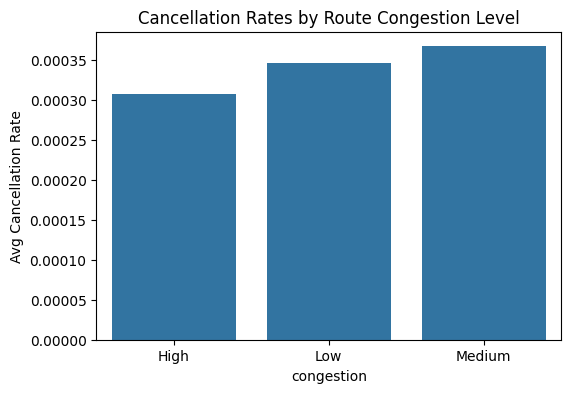

In [25]:
cong_cmp = route_stats.groupby("congestion")["cancel_rate"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=cong_cmp, x="congestion", y="cancel_rate")
plt.title("Cancellation Rates by Route Congestion Level")
plt.ylabel("Avg Cancellation Rate")
plt.show()


# Final Deliverables Summary

Week 6 deliverables (all plots + insights) are now complete:

✔ Seasonal Visuals

Monthly cancellation trend (line chart)

Cancellation type distribution (stacked bar)

Winter vs non-winter bar chart

Holiday impact bar chart

✔ Route Congestion Insights

Flights per route

Congestion categories

Cancellation rate vs congestion